In [2]:
# 일부만 할당된 GPU 메모리를 실행하는 동안 필요한만큼 늘릴 수 있도록 설정함
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [3]:
# 모델 학습 시 불필요한 출력을 끄도록 함 (waning)

tf.logging.set_verbosity(tf.logging.ERROR)

In [4]:
import numpy as np

np.random.seed(777)

# 1. 데이터 준비

In [5]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [6]:
print(train_images.shape)
print(len(train_images))
print(train_images.ndim)
print(train_images.dtype)

print()

print(train_labels)
print(train_labels.shape)
print(len(train_labels))
print(train_labels.ndim)
print(train_labels.dtype)

(60000, 28, 28)
60000
3
uint8

[5 0 4 ... 5 6 8]
(60000,)
60000
1
uint8


In [7]:
# train_labels = train_labels[:]+10
# test_labels = test_labels[:]+10

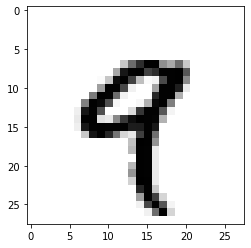

9


In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

digit = train_images[4]
label = train_labels[4]

plt.imshow(digit, cmap=plt.cm.binary)
plt.show()
print(label)

# ※ 참고

In [9]:
# from pylab import *
# from numpy import outer
# rc('text', usetex=False)
# a=outer(arange(0,1,0.01),ones(10))
# figure(figsize=(15,5))
# subplots_adjust(top=0.8,bottom=0.05,left=0.01,right=0.99)
# maps = [m for m in cm.datad if not m.endswith("_r")]
# maps.sort()
# l = len(maps)+1
# for i, m in enumerate(maps):
#     subplot(1,l,i+1)
#     axis("off")
#     imshow(a,aspect='auto',cmap=get_cmap(m),origin="lower")
#     title(m,rotation=90,fontsize=10)
# savefig("colormaps.png",dpi=100,facecolor='gray')

# 2. 데이터 전처리

In [10]:
train_images = train_images.reshape((60000, 28*28))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28*28))
test_images = test_images.astype('float32') / 255

from tensorflow.keras.utils import to_categorical

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [11]:
train_labels[4]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

# 3. 네트워크 정의

In [12]:
from keras.models import Sequential
from keras.layers import Dense 

model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(28*28,)))
model.add(Dense(10, activation='softmax'))

Using TensorFlow backend.


# 4. 컴파일
- 옵티마이저, 손실 함수, 성능 척도 정의

In [13]:
model.compile(optimizer = 'rmsprop',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

# 5. 모델 훈련시키기

In [18]:
hist = model.fit(train_images, 
                 train_labels, 
                 epochs=2, 
                 batch_size=128,
                 validation_data=(test_images, test_labels))

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 2s 31us/step - loss: 0.1057 - acc: 0.9694 - val_loss: 0.1252 - val_acc: 0.9630
Epoch 2/2
60000/60000 [==============================] - 2s 29us/step - loss: 0.0994 - acc: 0.9709 - val_loss: 0.1204 - val_acc: 0.9649


# 6. 모델 평가하기

In [34]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('test_acc:', test_acc)

10000/10000 [==============================] - 0s 43us/step
test_acc: 0.9334


In [35]:
import numpy as np

test_labels = test_labels.argmax(axis=-1)
pred_labels = model.predict(test_images).argmax(axis=-1)
print('target:', test_labels[0])
print('predict:', pred_labels[0])

target: 7
predict: 7


# ※ 오류 분석(error analysis)

In [36]:
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(test_labels, pred_labels) # pred는 value로 전달
print(cm)

[[ 957    0    0    1    0    4   11    3    4    0]
 [   0 1094    5    2    1    1    4    3   25    0]
 [  10    1  944    2   14    2    7   13   38    1]
 [   3    0   22  895    2   28    1   16   37    6]
 [   1    1    4    0  932    0   11    2    6   25]
 [  10    1    2   24   10  780   21    6   31    7]
 [   8    3    5    0    5    7  925    1    4    0]
 [   1    7   21    3    6    0    1  967    1   21]
 [   5    2    7    7    7    9   10   10  914    3]
 [   8    4    1    5   34    5    1   13   12  926]]


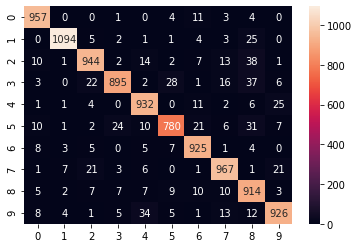

In [37]:
import pandas as pd
import seaborn as sns

df_cm = pd.DataFrame(cm)
heatmap = sns.heatmap(df_cm, annot=True, fmt='d')

In [38]:
X_33 = test_images[(test_labels == 3) & (pred_labels == 3)]
X_35 = test_images[(test_labels == 3) & (pred_labels == 5)]
X_53 = test_images[(test_labels == 5) & (pred_labels == 3)]
X_55 = test_images[(test_labels == 5) & (pred_labels == 5)]

print(X_33.shape)
print(X_35.shape)
print(X_53.shape)
print(X_55.shape)

(895, 784)
(28, 784)
(24, 784)
(780, 784)


In [39]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = 'binary', **options)
    plt.axis("off")

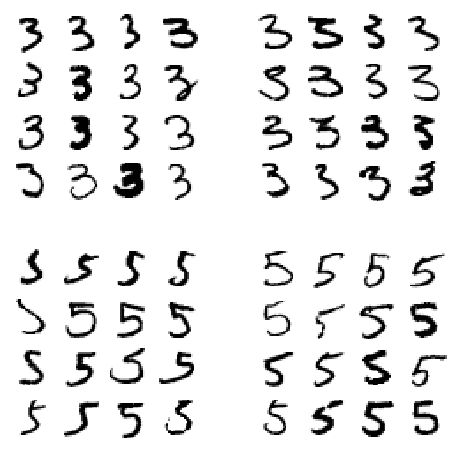

In [40]:
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_33[:16], images_per_row=4)
plt.subplot(222); plot_digits(X_35[:16], images_per_row=4)
plt.subplot(223); plot_digits(X_53[:16], images_per_row=4)
plt.subplot(224); plot_digits(X_55[:16], images_per_row=4)
plt.show()